# **Линейная регрессия на реальных данных климатической модели ИВМ РАН версии INM-CM6P.** 

Используются <u>среднемесячные</u> поля - **температура поверхности океана (ТПО), температура воздуха на 2 м (Т2), давление на уровне моря (ДУМ) и атмосферные осадки (АО)** для периода января 1960 г. - декабря 2014 г. для точки с коррдинатами 15.75 $^{\circ}$ с.ш., 60 $^{\circ}$ з.д., расположенной в области распространения ЭНЮК. 

*Шаг модели - 1.5 $^{\circ}$ от 90 $^{\circ}$ ю.ш. до 90 $^{\circ}$ с.ш. и 2 $^{\circ}$ от 180 $^{\circ}$ з.д. до 180 $^{\circ}$ в.д.*

In [34]:
# импорт всех необходимых библиотек
import os
import sklearn
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, ConfusionMatrixDisplay, accuracy_score

### Считываем данные модели INM-CM6P как в прошлом задании

In [35]:
df = pd.read_csv('SST_1960_2024.csv', parse_dates=['time'])
df['time'] = df['time'].dt.strftime('%Y-%m')
df = df.set_index('time')
df.head()

,lat,lon,SST,T2,PS,PREC
time,,,,,,
1960-01,15.75,-60.0,24.563684,22.784052,1016.594604,57.730061
1960-02,15.75,-60.0,23.691187,22.297662,1017.168457,40.946360
1960-03,15.75,-60.0,23.696558,22.015161,1015.526978,27.165576
1960-04,15.75,-60.0,24.496667,23.617761,1014.915100,21.852676
1960-05,15.75,-60.0,24.893915,24.117120,1015.490417,26.074183


### Применяем **модель линейной регрессии** для ТПО

In [36]:
df_Xy = df.copy().drop(columns=['lat', 'lon']).dropna()

y = df_Xy['SST'] # целевая переменная - ТПО
X = df_Xy.drop('SST', axis=1) # признаковое описание - Т2, ДУМ и АО

model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Text(0.5, 1.0, 'RMSE = 0.258, r = 0.967, $r^2$ = 0.934, R2 = 0.934')

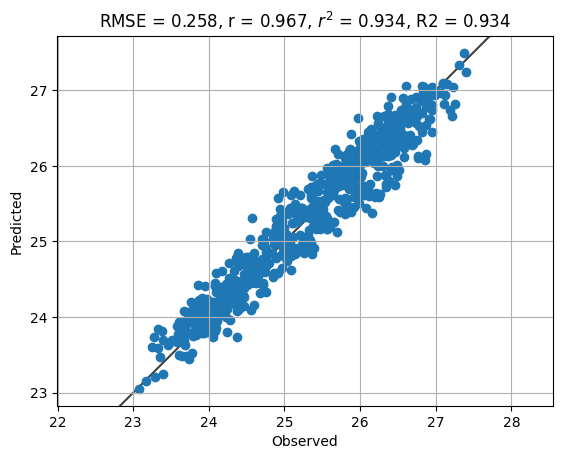

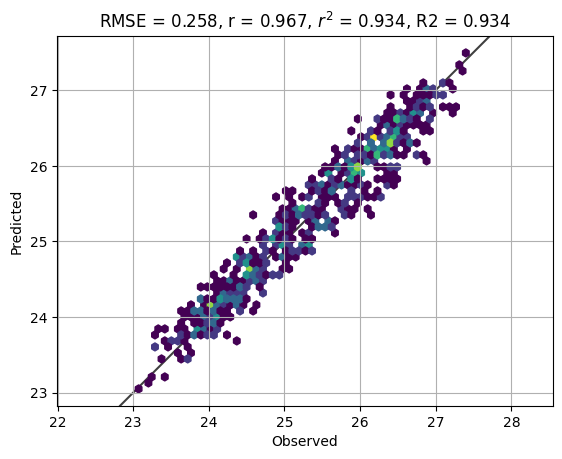

In [37]:
y_pred = model.predict(X)

plt.figure()
plt.scatter(y, y_pred)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

r = np.corrcoef(y_pred, y)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y, y_pred) # вычисляем СКО

plt.title ('RMSE = %.3f, r = %.3f, $r^2$ = %.3f, R2 = %.3f'%(np.sqrt (mse), r, r**2, r2))

plt.figure()
plt.hexbin(y, y_pred, mincnt=1, gridsize=50)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

r = np.corrcoef(y_pred, y)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y, y_pred) # вычисляем СКО

plt.title ('RMSE = %.3f, r = %.3f, $r^2$ = %.3f, R2 = %.3f'%(np.sqrt (mse), r, r**2, r2))

На основании полученных графиков можем сделать вывод, что используемая нами <u>модель линейной регрессии</u> **достаточно успешно** прогнозирует ТПО по данным Т2, ДУМ и АО. Имеем большие значения коэффициентов корреляции (**крайне высокая** линейная <u>положительная</u> связь между "реальными" и "моделируемыми" значениями ТПО) и детерминации (модель интерпретирует практически **всю изменчивость** ТПО) и достаточно небольшую величину СКО (**большая точность** используемой модели), что также свидетельствует о **высоком качестве воспроизведения** ТПО нашей моделью линейной регрессии.

### Посмотрим на коэффициенты регрессии линейной модели $\theta$

,coef
T2,0.802659
PS,-0.057576
PREC,0.001676


Text(0.5, 1.0, 'Коэффициенты регрессии линейной модели')

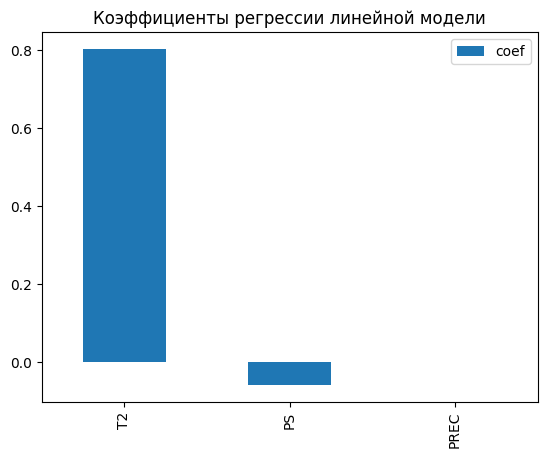

In [38]:
coefs = pd.DataFrame(model.coef_, X.columns, columns=['coef']) 
display(coefs)
coefs.plot.bar()
plt.title(r'Коэффициенты регрессии линейной модели')

**Наибольший коэффициент регрессии линейной модели $\theta$**, как и следовало ожидать, получаем для температуры воздуха на уровне 2 м (температура поверхности и воздуха на 2 м - **крайне взаимосвязанные** и **взаимообуславливающие** друг друга показатели). Т.е. **наиболее значительным** "предиктором" ТПО выступает именно Т2. На "промежуточном" месте находится коэффициент регрессии $\theta$ между ТПО и ДУМ - важно также отметить, что он <u>отрицателен</u>, т.е. при <u>увеличении</u> давления наблюдается <u>уменьшение</u> температуры (*ночное выхолаживание поверхности в условиях ясной погоды*). **Наименьшее значение** имеет коэффициент регрессии $\theta$ ТПО по АО (слабое влияние в <u>положительную</u> сторону) - *моделирование поля осадков представляют собой достаточно трудную задачу и связь между ним и полем ТПО крайне <u>сложна</u>*.

### Теперь проделаем всё то же самое, но уже с разделением на **тренировочную** и **тестовую выборки**

,coef
T2,0.786418
PS,-0.058511
PREC,0.001847


Text(0.5, 1.0, 'Коэффициенты регрессии линейной модели')

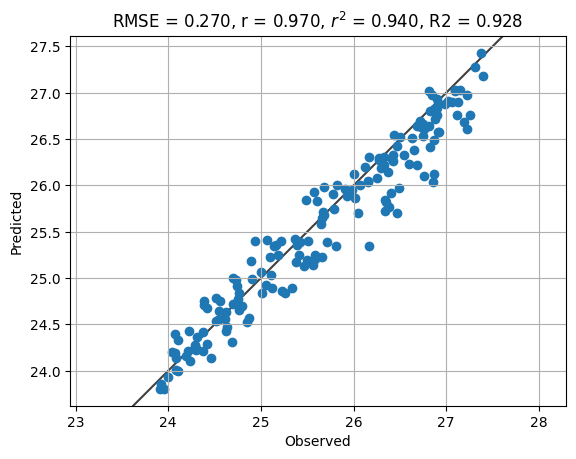

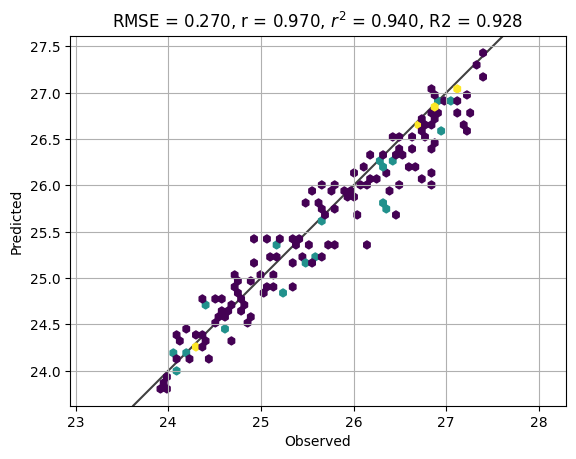

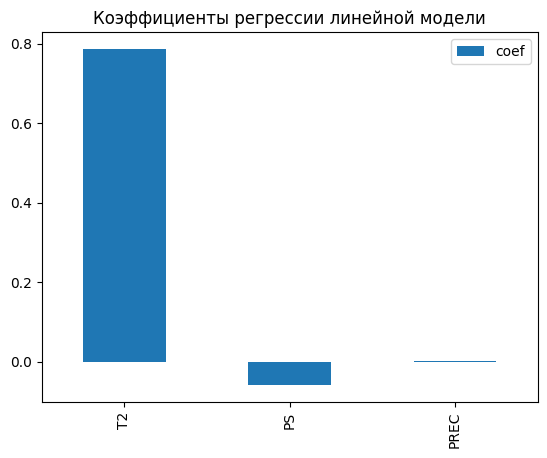

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  shuffle=False) 
#display(X_train)
#display(X_test)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

r = np.corrcoef(y_pred, y_test)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y_test, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y_test, y_pred) # вычисляем СКО

plt.title ('RMSE = %.3f, r = %.3f, $r^2$ = %.3f, R2 = %.3f'%(np.sqrt (mse), r, r**2, r2))

plt.figure()
plt.hexbin(y_test, y_pred, mincnt=1, gridsize=50)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

r = np.corrcoef(y_pred, y_test)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y_test, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y_test, y_pred) # вычисляем СКО

plt.title ('RMSE = %.3f, r = %.3f, $r^2$ = %.3f, R2 = %.3f'%(np.sqrt (mse), r, r**2, r2))

coefs = pd.DataFrame(model.coef_, X.columns, columns=['coef']) 
display(coefs)
coefs.plot.bar()
plt.title(r'Коэффициенты регрессии линейной модели')

Представленные графики позволяют заключить, что <u>модель линейной регрессии</u> **достаточно хорошо** воспроизводит ТПО по данным Т2, ДУМ и АО. Получены **большие коэффициенты корреляции** (прочная линейная <u>положительная</u> связь между "реальными" и "прогнозируемыми моделью" значениями ТПО) и детерминации (модель интерпретирует **большую часть** изменчивости ТПО) и относительно малую величину СКО (**большая точность** используемой модели). *Интересно отметить, что в отличие от "неразделенной" на тренировочную и тестовую исходной выборки, для которой квадрат коэффициента корреляции и коэффициент детерминации <u>совпадали</u>, в случае тестовой выборки такая закономерность **НЕ** выполняется*.

Аналогично полной исходной выборке, **наибольший коэффициент регрессии линейной модели $\theta$** (*вес*) имеет Т2, поскольку температура поверхности и температура воздуха на 2 м являются крайне **связанными** величинами. Коэффициент регрессии $\theta$ между ТПО и ДУМ имеет тот же порядок и знак, что и для исходной неразделенной выборки. **Наименьшее значение** коэффициента регрессии $\theta$ получено для АО (<u>положительная</u> связь), но надо отметить, что по сравнению с исходной выборкой он имеет <u>несколько больший</u> вес (на 0.000171).

### Проанализируем влияние масштабирования признаков на качество модели линейной регрессии

,coef
T2,0.914762
PS,-0.043969
PREC,0.048181


Text(0.5, 1.0, 'Коэффициенты регрессии линейной модели')

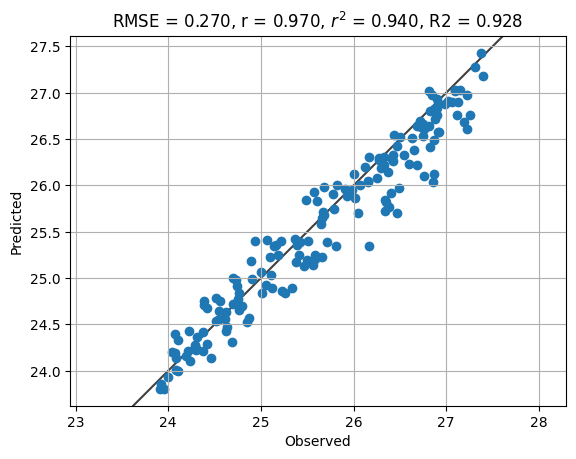

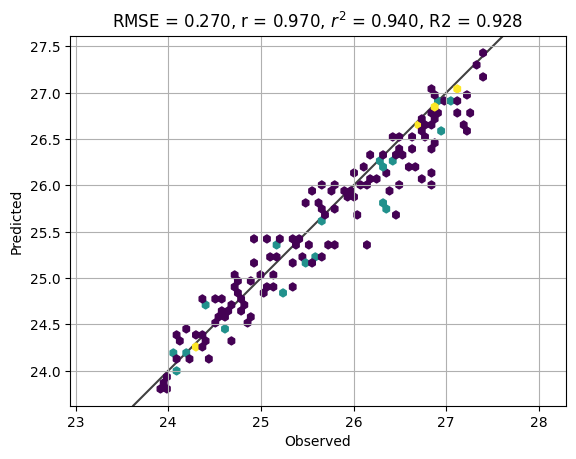

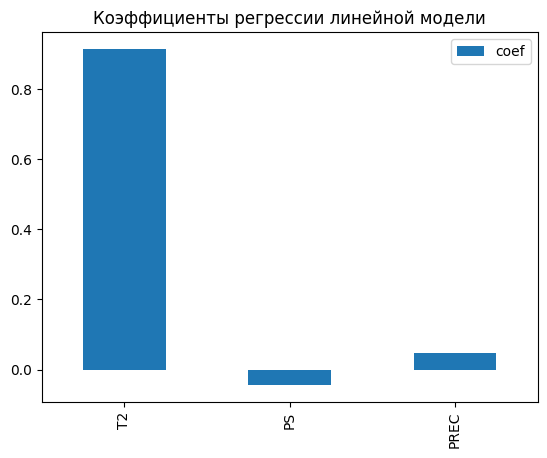

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

r = np.corrcoef(y_pred, y_test)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y_test, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y_test, y_pred) # вычисляем СКО

plt.title ('RMSE = %.3f, r = %.3f, $r^2$ = %.3f, R2 = %.3f'%(np.sqrt (mse), r, r**2, r2))

plt.figure()
plt.hexbin(y_test, y_pred, mincnt=1, gridsize=50)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

r = np.corrcoef(y_pred, y_test)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y_test, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y_test, y_pred) # вычисляем СКО

plt.title ('RMSE = %.3f, r = %.3f, $r^2$ = %.3f, R2 = %.3f'%(np.sqrt (mse), r, r**2, r2))

coefs = pd.DataFrame(model.coef_, X.columns, columns=['coef']) 
display(coefs)
coefs.plot.bar()
plt.title(r'Коэффициенты регрессии линейной модели')

<u>Масштабирование признаков</u> **НЕ** привело к изменению значений коэффициентов корреляции и детерминации, а также СКО - это **НЕ** является ошибкой, поскольку масштабирование признаков является <u>линейным преобразованием</u>. Но, как и следовало ожидать, наблюдается изменение **коэффициентов регрессии линейной модели $\theta$** - так, температура воздуха на 2 м и осадки приобретают **больший вес** (положительные значения) с **максимумом** для температуры (на 0.129 больше по сравнению с исходной тестовой выборкой), тогда как давление приобретает **меньший (по модулю)** коэффициент.

### Реализуем порождение новых признаков и проанализируем их влияние на качество модели линейной регрессии

C:\Users\1\AppData\Local\Temp\ipykernel_13416\486356397.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='bfill')


,coef
T2,0.395362
PS,-0.017674
PREC,0.004595
T2_anom,0.395362
PS_ind,-0.023207
PREC_grad,-0.003567


Text(0.5, 1.0, 'Коэффициенты регрессии линейной модели')

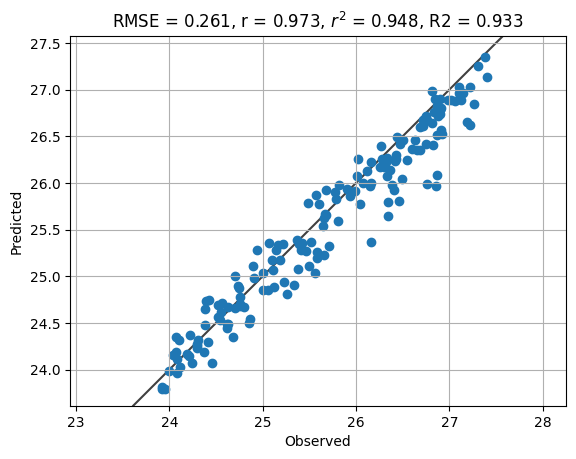

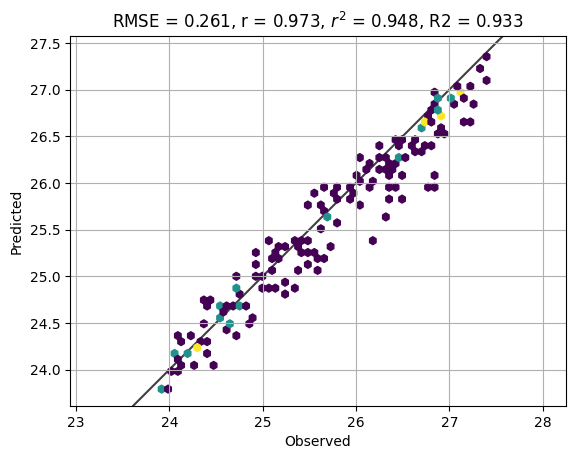

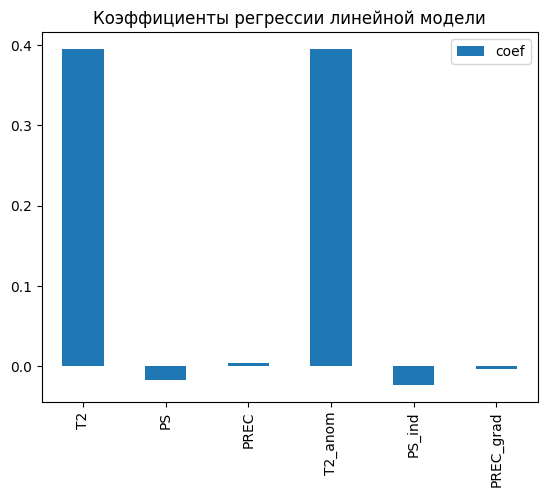

In [46]:
features = df.copy()
features['T2_anom'] = features['T2'] - features['T2'].mean() # считаем аномалию для Т2
features['PS_ind'] = (features['PS'] - features['PS'].mean()) / features['PS'].std() # считаем индекс для ДУМ
features['SST_ind'] = (features['SST'] - features['SST'].mean()) / features['SST'].std() # считаем индекс для ТПО
features['PREC_grad'] = features['PREC'].diff() # считаем градиент для АО
features = features.fillna(method='bfill')

features = features.copy().drop(columns=['lat', 'lon']).dropna()

y = features['SST'] # целевая переменная - ТПО
X = features.drop(['SST_ind', 'SST'], axis=1) # признаковое описание - все остальные переменные (кроме индекса для ТПО)

model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  shuffle=False) 
#display(X_train)
#display(X_test)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

r = np.corrcoef(y_pred, y_test)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y_test, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y_test, y_pred) # вычисляем СКО

plt.title ('RMSE = %.3f, r = %.3f, $r^2$ = %.3f, R2 = %.3f'%(np.sqrt (mse), r, r**2, r2))

plt.figure()
plt.hexbin(y_test, y_pred, mincnt=1, gridsize=50)
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')

r = np.corrcoef(y_pred, y_test)[0,1] # вычисляем коэффициент корреляции
r2 = r2_score(y_test, y_pred) # вычисляем коэффициент детерминации
mse = mean_squared_error(y_test, y_pred) # вычисляем СКО

plt.title ('RMSE = %.3f, r = %.3f, $r^2$ = %.3f, R2 = %.3f'%(np.sqrt (mse), r, r**2, r2))

coefs = pd.DataFrame(model.coef_, X.columns, columns=['coef']) 
display(coefs)
coefs.plot.bar()
plt.title(r'Коэффициенты регрессии линейной модели')

Полученные графики позволяют высказать предположение, что <u>модель линейной регрессии</u> воспроизводит ТПО по данным Т2, аномалии для Т2, ДУМ, индексу для ДУМ, АО и градиенту для АО в **достаточно высоком качестве**. Получены **несколько большие**, по сравнению с исходным массивом, коэффициенты корреляции и детерминации и **меньшая** СКО. 

Значительные изменения претерпели **коэффициенты регрессии линейной модели $\theta$** - **одинаковый** вклад (*в сумме примерно равный вкладу Т2 для исходного массива данных*) приобрели Т2 и аномалия для Т2; коэффициент ДУМ и коэффициент для его индекса <u>по модулю</u> в сумме **меньше** коэффициента ДУМ для исходного массива (на 0.018); вес АО и градиента для АО имеет <u>противоположный знак</u> (в сумме их вес равен весу АО для исходного массива данных).

### Применяем модель логистической регрессии для АО

Precipitation category distribution: precipitation_category
moderate      196
very heavy    153
small         153
heavy         125
very small     33
Name: count, dtype: int64
Точность модели: 0.3621212121212121


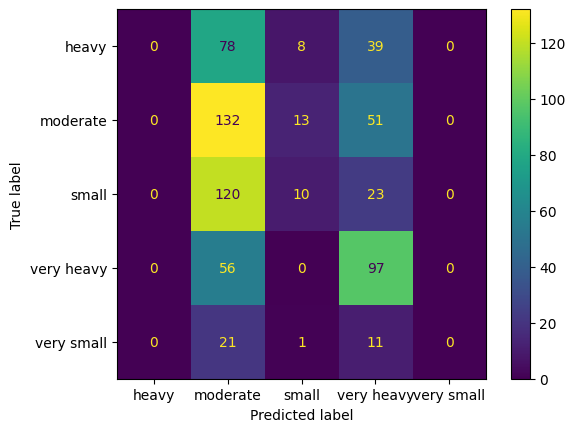

In [48]:
df_Xy = df.copy().drop(columns=['lat', 'lon']).dropna()

# Задаем классы интенсивности осадков
def categorize_precipitation(precipitation):
    if precipitation < 20:
        return 'very small'
    elif precipitation > 20 and precipitation < 30:
        return 'small'
    elif precipitation > 30 and precipitation < 40:
        return 'moderate'
    elif precipitation > 40 and precipitation < 50:
        return 'heavy'
    elif precipitation > 50:
        return 'very heavy'

# Применяем классификацию
df_Xy['precipitation_category'] = df_Xy['PREC'].apply(categorize_precipitation)

print("Precipitation category distribution:", df_Xy['precipitation_category'].value_counts()) # в сумме - 660 случаев, что соответствует количеству временных срезов

y = df_Xy['precipitation_category'] # целевая переменная - интенсивность АО
X = df_Xy.drop(columns=['PREC', 'precipitation_category']) # признаковое описание - ТПО, Т2 и ДУМ

# Fit the model
model = LogisticRegression(max_iter=10000)
model.fit(X, y)

y_pred = model.predict(X)
_ = ConfusionMatrixDisplay.from_estimator(model, X, y)

accuracy = accuracy_score(y, y_pred)
print(f"Точность модели:", accuracy)

На основе полученной <u>матрицы ошибок</u> можно сделать вывод, что модель **очень плохо прогнозирует** **сильные** (*от 40 до 50 мм/сут*) и **очень слабые** (*менее 20 мм/сут*) осадки. **Лучшие результаты** получаются для **умеренных** (*30-40 мм/сут*) и **очень сильных** (*более 50 мм/сут*) осадков. **Малая точность** прослеживается для **слабых** осадков (*20-30 мм/сут*). Чаще всего модель "путает" **слабые** осадки с **умеренными**, **сильные** и **очень сильные** с **умеренными**, **умеренные** с **очень сильными**. Полученное значение <u>точности модели</u> (0.36) также свидетельствует о **невысоком качестве воспроизведения** поля осадков моделью логистической регресии. *Но надо отметить, что для осадков использовалась очень <u>грубая абстрактная классификация</u> и поле осадков является одним из наиболее <u>трудно воспроизводимых</u> метеорологических полей*.

### Используем модель логистической регрессии для тренировочной и тестовой выборок

Точность модели: 0.32727272727272727


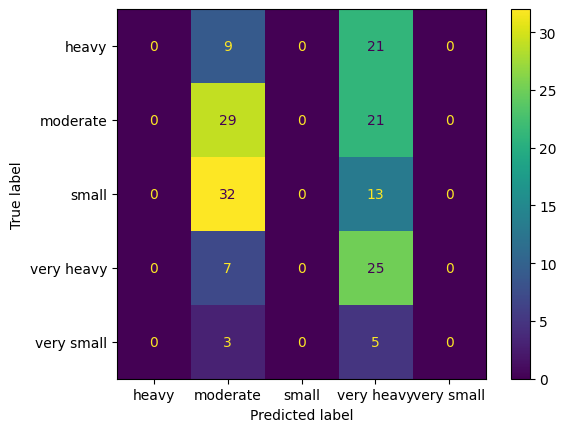

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  shuffle=False) 
#display(X_train)
#display(X_test)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
_ = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели:", accuracy)

Представленная <u>матрица ошибок</u> позволяет заключить, что модель логистической регрессии, примененная к тестовой выборке, **плохо прогнозирует** **сильные** (*от 40 до 50 мм/сут*), **слабые** (*20-30 мм/сут*) и **очень слабые** (*менее 20 мм/сут*) осадки. Как и в случае исходной неразделенной выборки, **наиболее качественно** прогнозируются **умеренные** (*30-40 мм/сут*) и **очень сильные** (*более 50 мм/сут*) осадки. Сильнее всего модель "путает" **слабые** осадки с **умеренными**, **сильные** и **умеренные** с **очень сильными**. <u>Точность</u> модели меньше, чем для исходной выборки (на 0.03), что также подтверждает **низкое качество** применяемой модели.

### Проанализируем влияние масштабирования признаков на качество модели логистической регрессии

Точность модели: 0.36363636363636365


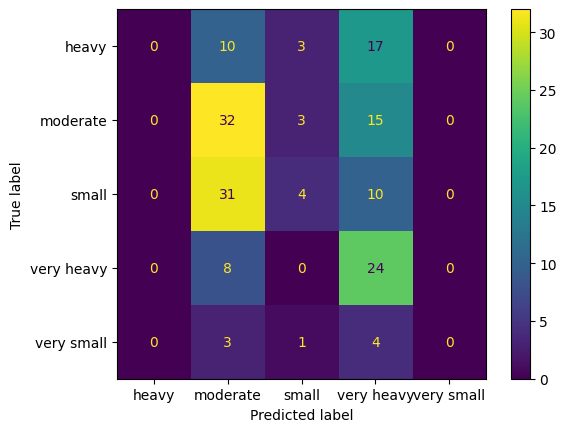

In [50]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

_ = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели:", accuracy)

<u>Масштабирование признаков</u> привело к изменению <u> точности</u> модели логистической регрессии - она **повысилась** (на 0.03). Как и в случае исходных немасштабированных признаков, модель  **плохо прогнозирует** **сильные** (*от 40 до 50 мм/сут*) и **очень слабые** (*менее 20 мм/сут*) осадки. **Наиболее качественно** прогнозируются **умеренные** (*30-40 мм/сут*) и **очень сильные** (*более 50 мм/сут*) осадки. **Низкое качество** наблюдается для **слабых** (*20-30 мм/сут*) осадков. Чаще всего модель "путает" **слабые** осадки с **умеренными** и **сильные** с **очень сильными**.